<a href="https://colab.research.google.com/github/matusoff/ML_models/blob/main/GNN_Cora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## implementation of a Graph Neural Network (GNN) model. The model is used for a node prediction task on the Cora dataset to predict the subject of a paper given its words and citations network.

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Prepare the Dataset
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

168052/168052 [==============================] - 0s 1us/step


In [3]:
# Process and visualize the dataset
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [4]:
citations.sample(frac=1).head()

,target,source
2151,18615,582343
4675,248395,1113828
4455,190698,190697
4661,240321,675847
1621,8872,395075


In [5]:
#  Let's load the papers data into a Pandas DataFrame
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [6]:
print(papers.sample(5).T)

             574            1312             544              180     2099
paper_id    67415          18615          1129442          1112426   28641
term_0          0              0                0                0       0
term_1          0              0                0                0       0
term_2          0              0                0                0       0
term_3          1              0                0                0       0
...           ...            ...              ...              ...     ...
term_1429       0              0                0                0       0
term_1430       0              0                0                0       0
term_1431       0              0                0                0       0
term_1432       0              0                0                0       0
subject    Theory  Rule_Learning  Neural_Networks  Neural_Networks  Theory

[1435 rows x 5 columns]


In [7]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


In [8]:
# Convert the paper ids and the subjects into zero-based indices.

class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

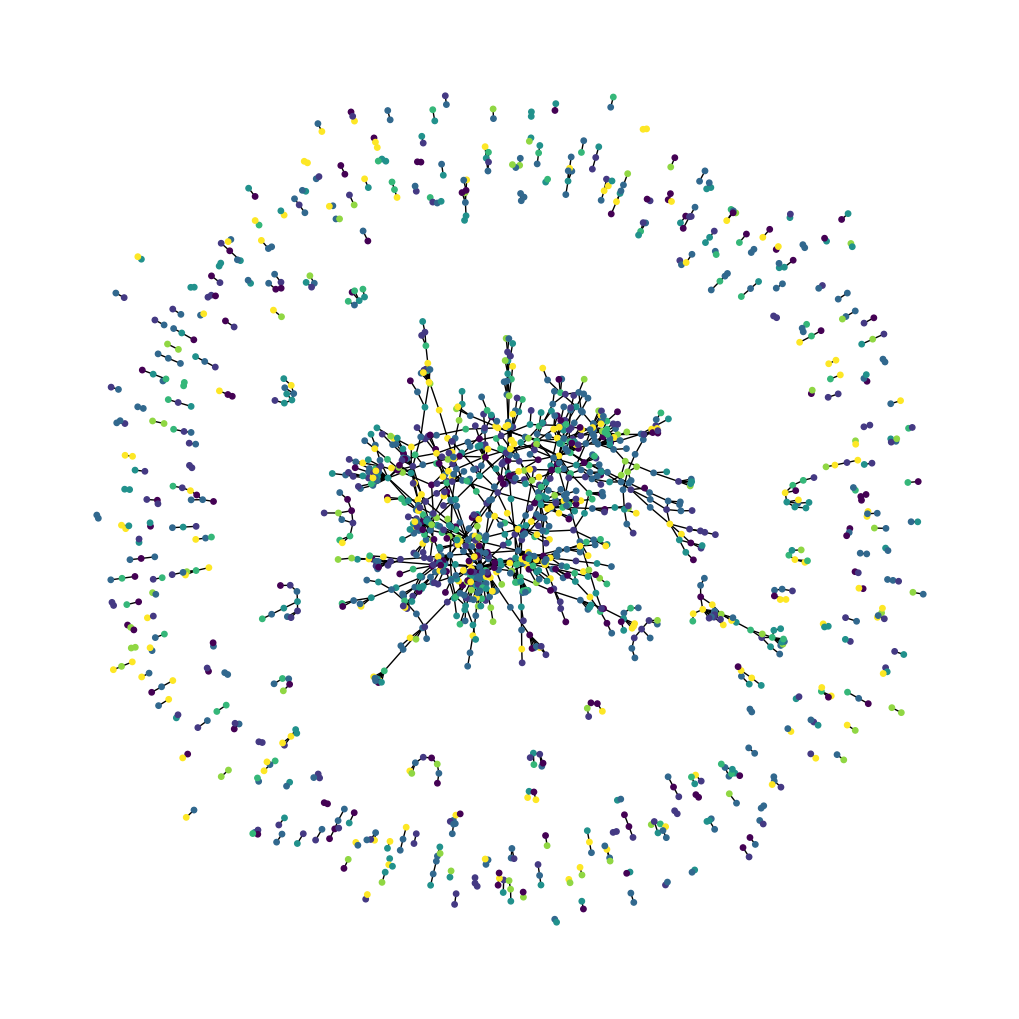

In [9]:
#  Visualize the citation graph.

plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [10]:
# Split the dataset into stratified train and test sets
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1328, 1435)
Test data shape: (1380, 1435)


In [11]:
# Implement Train and Evaluate Experiment
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [12]:
# Function to compily and train an input model using the given training data

def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [13]:
# Function to display the loss and accuracy curves of the model during training.

def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [14]:
# Implement Feedforward Network (FFN) Module

def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [15]:
# Build a Baseline Neural Network Model

feature_names = list(set(papers.columns) - {"paper_id", "subject"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [16]:
# Implement a baseline classifier

def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_features (InputLayer  [(None, 1433)]               0         []                            
 )                                                                                                
                                                                                                  
 ffn_block1 (Sequential)     (None, 32)                   52804     ['input_features[0][0]']      
                                                                                                  
 ffn_block2 (Sequential)     (None, 32)                   2368      ['ffn_block1[0][0]']          
                                                                                                  
 skip_connection2 (Add)      (None, 32)                   0         ['ffn_block1[0][0]',   

In [17]:
# Train the baseline classifier
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 10s 181ms/step - loss: 3.8238 - acc: 0.1773 - val_loss: 1.9777 - val_acc: 0.1400
Epoch 2/300
5/5 [==============================] - 0s 37ms/step - loss: 2.7311 - acc: 0.2137 - val_loss: 1.9413 - val_acc: 0.1600
Epoch 3/300
5/5 [==============================] - 0s 30ms/step - loss: 2.3554 - acc: 0.2553 - val_loss: 1.9113 - val_acc: 0.1500
Epoch 4/300
5/5 [==============================] - 0s 34ms/step - loss: 2.2034 - acc: 0.2651 - val_loss: 1.8929 - val_acc: 0.1750
Epoch 5/300
5/5 [==============================] - 0s 34ms/step - loss: 2.0175 - acc: 0.2917 - val_loss: 1.8726 - val_acc: 0.2700
Epoch 6/300
5/5 [==============================] - 0s 33ms/step - loss: 1.9391 - acc: 0.2890 - val_loss: 1.8733 - val_acc: 0.2750
Epoch 7/300
5/5 [==============================] - 0s 31ms/step - loss: 1.7995 - acc: 0.3369 - val_loss: 1.8733 - val_acc: 0.2450
Epoch 8/300
5/5 [==============================] - 0s 32ms/step - loss: 1.7169 - acc: 0.

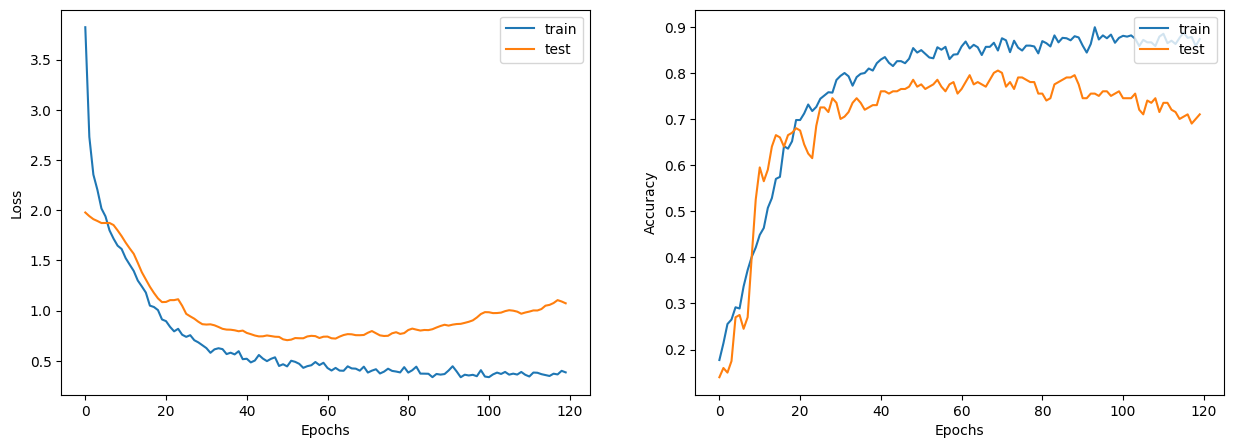

In [18]:
#  Learning curves
display_learning_curves(history)

In [19]:
# Evaluate the baseline model on the test data split
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 73.55%


In [20]:
# Examine the baseline model predictions
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

In [21]:
# Baseline model predictions given these randomly generated instances.

new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 [==============================] - 1s 766ms/step
Instance 1:
- Case_Based: 5.49%
- Genetic_Algorithms: 6.13%
- Neural_Networks: 6.76%
- Probabilistic_Methods: 34.56%
- Reinforcement_Learning: 13.62%
- Rule_Learning: 9.6%
- Theory: 23.85%
Instance 2:
- Case_Based: 1.02%
- Genetic_Algorithms: 1.58%
- Neural_Networks: 87.86%
- Probabilistic_Methods: 1.69%
- Reinforcement_Learning: 1.7%
- Rule_Learning: 0.57%
- Theory: 5.57%
Instance 3:
- Case_Based: 0.13%
- Genetic_Algorithms: 98.56%
- Neural_Networks: 0.65%
- Probabilistic_Methods: 0.18%
- Reinforcement_Learning: 0.16%
- Rule_Learning: 0.16%
- Theory: 0.17%
Instance 4:
- Case_Based: 2.94%
- Genetic_Algorithms: 32.43%
- Neural_Networks: 22.16%
- Probabilistic_Methods: 1.83%
- Reinforcement_Learning: 1.74%
- Rule_Learning: 31.74%
- Theory: 7.16%
Instance 5:
- Case_Based: 0.5%
- Genetic_Algorithms: 1.88%
- Neural_Networks: 85.97%
- Probabilistic_Methods: 6.6%
- Reinforcement_Learning: 0.21%
- Rule_Learning: 0.12%
- Theory: 4.71%
Instanc

In [22]:
# Build a Graph Neural Network Model

# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T

# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])

# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)

# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [23]:
# Implement a graph convolution layer
def create_gru(hidden_units, dropout_rate):
    inputs = keras.layers.Input(shape=(2, hidden_units[0]))
    x = inputs
    for units in hidden_units:
      x = layers.GRU(
          units=units,
          activation="tanh",
          recurrent_activation="sigmoid",
          return_sequences=True,
          dropout=dropout_rate,
          return_state=False,
          recurrent_dropout=dropout_rate,
      )(x)
    return keras.Model(inputs=inputs, outputs=x)


class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gru":
            self.update_fn = create_gru(hidden_units, dropout_rate)
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [24]:
# Implement a graph neural network node classifier

class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [25]:
# Install and run GNN model

gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 7.88833275e-02  2.99872831e-03 -8.40202272e-02 -1.77718297e-01
  -1.04980156e-01  2.35402510e-02  1.78398043e-01]
 [ 4.38630655e-02  4.38144356e-02  1.36057502e-02 -1.73596397e-01
  -4.70619760e-02  1.11742169e-02  4.25995290e-02]
 [-9.06763971e-03 -1.04546577e-01  2.00085342e-05 -4.22361344e-02
  -1.14430197e-01 -7.67366663e-02  1.17404893e-01]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLaye  multiple                  5888      
 r)                                                              
                                                                 
 graph_conv2 (GraphConvLaye  multiple                  5888      
 r)                                       

In [26]:
# Train the GNN model

x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 13s 333ms/step - loss: 2.2792 - acc: 0.1773 - val_loss: 1.9170 - val_acc: 0.2650
Epoch 2/300
5/5 [==============================] - 1s 181ms/step - loss: 2.0325 - acc: 0.2314 - val_loss: 1.8913 - val_acc: 0.3600
Epoch 3/300
5/5 [==============================] - 1s 181ms/step - loss: 1.9203 - acc: 0.2722 - val_loss: 1.8827 - val_acc: 0.3650
Epoch 4/300
5/5 [==============================] - 1s 180ms/step - loss: 1.8941 - acc: 0.2606 - val_loss: 1.8819 - val_acc: 0.3400
Epoch 5/300
5/5 [==============================] - 1s 182ms/step - loss: 1.8651 - acc: 0.2757 - val_loss: 1.8750 - val_acc: 0.3300
Epoch 6/300
5/5 [==============================] - 1s 185ms/step - loss: 1.8375 - acc: 0.2934 - val_loss: 1.8644 - val_acc: 0.3300
Epoch 7/300
5/5 [==============================] - 1s 175ms/step - loss: 1.8321 - acc: 0.3023 - val_loss: 1.8534 - val_acc: 0.3700
Epoch 8/300
5/5 [==============================] - 1s 206ms/step - loss: 1.8191 - 

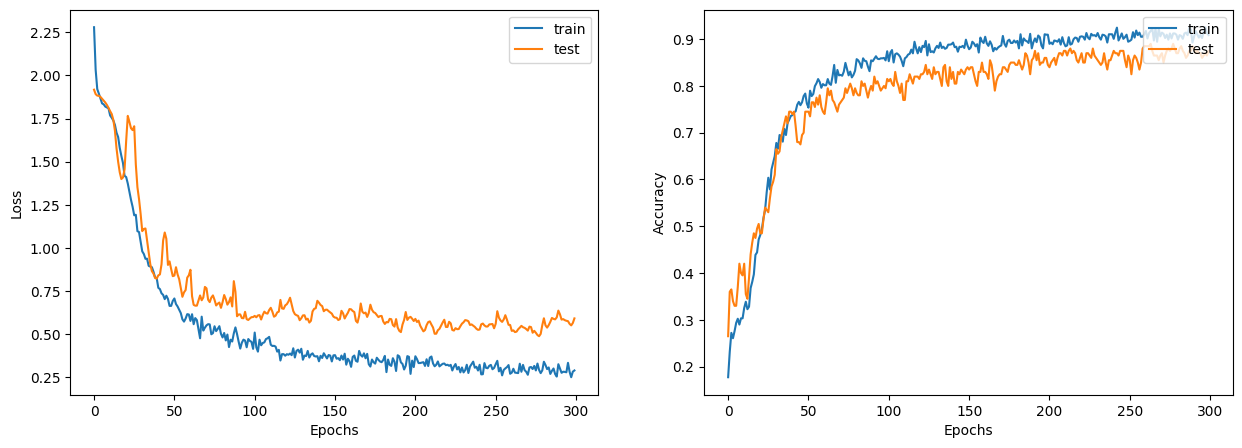

In [27]:
display_learning_curves(history)

In [28]:
# evaluate the GNN model on the test data split
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 81.81%


In [29]:
# Examine the GNN model predictions

# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [30]:
# update the node_features and the edges in the GNN model.

print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
1/1 [==============================] - 3s 3s/step
Instance 1:
- Case_Based: 48.31%
- Genetic_Algorithms: 0.85%
- Neural_Networks: 1.92%
- Probabilistic_Methods: 12.25%
- Reinforcement_Learning: 1.73%
- Rule_Learning: 4.94%
- Theory: 30.0%
Instance 2:
- Case_Based: 0.02%
- Genetic_Algorithms: 99.02%
- Neural_Networks: 0.33%
- Probabilistic_Methods: 0.02%
- Reinforcement_Learning: 0.49%
- Rule_Learning: 0.06%
- Theory: 0.06%
Instance 3:
- Case_Based: 0.46%
- Genetic_Algorithms: 1.3%
- Neural_Networks: 91.23%
- Probabilistic_Methods: 3.4%
- Reinforcement_Learning: 0.21%
- Rule_Learning: 1.36%
- Theory: 2.05%
Instance 4:
- Case_Based: 3.68%
- Genetic_Algorithms: 0.17%
- Neural_Networks: 5.52%
- Probabilistic_Methods: 88.87%
- Reinforcement_Learning: 0.16%
- Rule_Learning: 0.13%
- Theory: 1.47%
Instance 5:
- Case_Based: 0.03%
- Genetic_Algorithms: 0.88%

Now the probabilities of the expected subjects (to which several citations are added) are higher compared to the baseline model.